# Advanced House Price Prediction: Kaggle competition

# Link for the dataset is: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

# Data Dictionary can be found in the same link

# Submitted by: Shankar Pendse (R00195877)

In [1]:
# Import the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import normalize, PolynomialFeatures

from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

In [2]:
def read_data(datafile):
    return pd.read_csv(datafile)

In [3]:
def preprocess_categorical_features(train_df, test_df):
    # Street: Type of road access to property either gravel or paved. Let's encode Grvl as 0 and Pave as 1,
    # since we have only two types associated with it(discrete values), lets give 0 value to Grvl and 1 value to Pave, so that pave
    # gets more weight

    train_df['Street'] = train_df['Street'].replace({'Grvl':0, 'Pave': 1})
    test_df['Street'] = test_df['Street'].replace({'Grvl':0, 'Pave': 1})
    
    # Alley: Type of alley access to property. 
    # It is given that, If the value for this attribute is nan, it means that the property has no Alley access
    # Let's use 0 for no access and 1 if it has alley access irrespective whether it is Grvl or Paved

    train_df['Alley'] = train_df['Alley'].replace({np.nan:0,'Grvl':1, 'Pave':1 })
    test_df['Alley'] = test_df['Alley'].replace({np.nan:0,'Grvl':1, 'Pave':1 })
    
    # LotShape: General shape of the property. 
    # There are 4 types to this, regular, and 3 types of irregular,
    # Let's categorize this into two types, regular(Reg) and irregular(Irr).
    # Use 0 for irregular and 1 for regular

    train_df['LotShape'] = train_df['LotShape'].replace( {'Reg':1, 'IR1':0, 'IR2':0, 'IR3':0} )
    test_df['LotShape'] = test_df['LotShape'].replace( {'Reg':1, 'IR1':0, 'IR2':0, 'IR3':0} )
    
    # LandContour: Flatness of the property, as we have seen from the unique values for this attribute, it takes 4 different values, 
    # but let's change the name to IsLevel and represent with 1 if level and 0 if not

    train_df = train_df.rename(columns={'LandContour':'IsLevel'})
    train_df['IsLevel'] = train_df['IsLevel'].replace( {'Lvl':1, 'Bnk':0, 'Low':0, 'HLS':0} )

    test_df = test_df.rename(columns={'LandContour':'IsLevel'})
    test_df['IsLevel'] = test_df['IsLevel'].replace({'Lvl':1, 'Bnk':0, 'Low':0, 'HLS':0})
    
    # Utilities: It has only 2 unique values, AllPub & NoSeWa. 
    # Let's rename the column to AllUtilities and represent with 1 for all and 0 for partial

    train_df = train_df.rename(columns={'Utilities': 'AllUtilities'})
    train_df['AllUtilities'] = train_df['AllUtilities'].replace( {'AllPub':1, 'NoSeWa':0} )

    test_df = test_df.rename(columns={'Utilities': 'AllUtilities'})
    test_df['AllUtilities'] = test_df['AllUtilities'].replace( {'AllPub':1, 'NoSeWa':0} )
    
    # LotConfig: It can take 5 Unique values,
    # let's use get_Dummies to represent this attribute in one-hot encoding format
    train_df = pd.get_dummies(data = train_df, columns= ['LotConfig'])
    test_df = pd.get_dummies(data = test_df, columns= ['LotConfig'])
    
    #Neighborhood : Let's use one hot encoding for this attribute 
    train_df = pd.get_dummies(data = train_df, columns= ['Neighborhood'])
    test_df = pd.get_dummies(data = test_df, columns = ['Neighborhood'])
    
    train_df = pd.get_dummies(data = train_df, columns= ['Condition1'])
    train_df = pd.get_dummies(data = train_df, columns = ['Condition2'])
    test_df = pd.get_dummies(data = test_df, columns = ['Condition1'])
    test_df = pd.get_dummies(data = test_df, columns = ['Condition2'])
    
    train_df = pd.get_dummies(data = train_df, columns = ['BldgType'])
    train_df = pd.get_dummies(data = train_df, columns = ['HouseStyle'])

    test_df = pd.get_dummies(data = test_df, columns = ['BldgType'])
    test_df = pd.get_dummies(data = test_df, columns = ['HouseStyle'])
    
    train_df = pd.get_dummies(data = train_df, columns = ['RoofStyle'])
    train_df = pd.get_dummies(data = train_df, columns = ['RoofMatl'])
    train_df = pd.get_dummies(data = train_df, columns = ['Exterior1st'])
    train_df = pd.get_dummies(data = train_df, columns = ['Exterior2nd'])
    train_df = pd.get_dummies(data = train_df, columns = ['MasVnrType'])

    test_df = pd.get_dummies(data = test_df, columns = ['RoofStyle'])
    test_df = pd.get_dummies(data = test_df, columns = ['RoofMatl'])
    test_df = pd.get_dummies(data = test_df, columns = ['Exterior1st'])
    test_df = pd.get_dummies(data = test_df, columns = ['Exterior2nd'])
    test_df = pd.get_dummies(data = test_df, columns = ['MasVnrType'])
    
    # Let's use ordinal encoding for ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC,
    # KitchenQual, Functional, FireplaceQu, GarageQual, GarageCond, PoolQC

    ExterQual_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
    ExterCond_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
    BsmtQual_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
    BsmtCond_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
    BsmtExposure_dict = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
    BsmtFinType1_dict = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
    BsmtFinType2_dict = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
    HeatingQC_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
    KitchenQual_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
    Functional_dict = {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1}
    FireplaceQu_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
    GarageQual_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
    GarageCond_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
    PoolQC_dict = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0}

    train_df['ExterQual'] = train_df['ExterQual'].map(ExterQual_dict)
    train_df['ExterCond'] = train_df['ExterCond'].map(ExterCond_dict)
    train_df['BsmtQual'] = train_df['BsmtQual'].map(BsmtQual_dict)
    train_df['BsmtCond'] = train_df['BsmtCond'].map(BsmtCond_dict)
    train_df['BsmtExposure'] = train_df['BsmtExposure'].map(BsmtExposure_dict)
    train_df['BsmtFinType1'] = train_df['BsmtFinType1'].map(BsmtFinType1_dict)
    train_df['BsmtFinType2'] = train_df['BsmtFinType2'].map(BsmtFinType2_dict)
    train_df['HeatingQC'] = train_df['HeatingQC'].map(HeatingQC_dict)
    train_df['KitchenQual'] = train_df['KitchenQual'].map(KitchenQual_dict)
    train_df['Functional'] = train_df['Functional'].map(Functional_dict)
    train_df['FireplaceQu'] = train_df['FireplaceQu'].map(FireplaceQu_dict)
    train_df['GarageQual'] = train_df['GarageQual'].map(GarageQual_dict)
    train_df['GarageCond'] = train_df['GarageCond'].map(GarageCond_dict)
    train_df['PoolQC'] = train_df['PoolQC'].map(PoolQC_dict)

    test_df['ExterQual'] = test_df['ExterQual'].map(ExterQual_dict)
    test_df['ExterCond'] = test_df['ExterCond'].map(ExterCond_dict)
    test_df['BsmtQual'] = test_df['BsmtQual'].map(BsmtQual_dict)
    test_df['BsmtCond'] = test_df['BsmtCond'].map(BsmtCond_dict)
    test_df['BsmtExposure'] = test_df['BsmtExposure'].map(BsmtExposure_dict)
    test_df['BsmtFinType1'] = test_df['BsmtFinType1'].map(BsmtFinType1_dict)
    test_df['BsmtFinType2'] = test_df['BsmtFinType2'].map(BsmtFinType2_dict)
    test_df['HeatingQC'] = test_df['HeatingQC'].map(HeatingQC_dict)
    test_df['KitchenQual'] = test_df['KitchenQual'].map(KitchenQual_dict)
    test_df['Functional'] = test_df['Functional'].map(Functional_dict)
    test_df['FireplaceQu'] = test_df['FireplaceQu'].map(FireplaceQu_dict)
    test_df['GarageQual'] = test_df['GarageQual'].map(GarageQual_dict)
    test_df['GarageCond'] = test_df['GarageCond'].map(GarageCond_dict)
    test_df['PoolQC'] = test_df['PoolQC'].map(PoolQC_dict)


    # It is given that for above features, nan means that particular feature is absent, so we will just replace nan with 0

    train_df['BsmtQual'] = train_df['BsmtQual'].fillna(0)
    train_df['BsmtCond'] = train_df['BsmtCond'].fillna(0)
    train_df['BsmtExposure'] = train_df['BsmtExposure'].fillna(0)
    train_df['BsmtFinType1'] = train_df['BsmtFinType1'].fillna(0)
    train_df['BsmtFinType2'] = train_df['BsmtFinType2'].fillna(0)
    train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna(0)
    train_df['GarageQual'] = train_df['GarageQual'].fillna(0)
    train_df['GarageCond'] = train_df['GarageCond'].fillna(0)
    train_df['PoolQC'] = train_df['PoolQC'].fillna(0)


    test_df['BsmtQual'] = test_df['BsmtQual'].fillna(0)
    test_df['BsmtCond'] = test_df['BsmtCond'].fillna(0)
    test_df['BsmtExposure'] = test_df['BsmtExposure'].fillna(0)
    test_df['BsmtFinType1'] = test_df['BsmtFinType1'].fillna(0)
    test_df['BsmtFinType2'] = test_df['BsmtFinType2'].fillna(0)
    test_df['FireplaceQu'] = test_df['FireplaceQu'].fillna(0)
    test_df['GarageQual'] = test_df['GarageQual'].fillna(0)
    test_df['GarageCond'] = test_df['GarageCond'].fillna(0)
    test_df['PoolQC'] = test_df['PoolQC'].fillna(0)
    
    train_df = pd.get_dummies(data = train_df, columns = ['Foundation'])
    test_df = pd.get_dummies(data = test_df, columns = ['Foundation'])
    
    train_df = pd.get_dummies(data = train_df, columns = ['Heating'])
    test_df = pd.get_dummies(data = test_df, columns = ['Heating'])
    
    train_df['CentralAir'] = train_df['CentralAir'].replace({'N':0, 'Y': 1})
    test_df['CentralAir'] = test_df['CentralAir'].replace({'N':0, 'Y': 1})
    
    train_df = pd.get_dummies(data = train_df, columns = ['Electrical'])
    test_df = pd.get_dummies(data = test_df, columns = ['Electrical'])
    
    train_df = pd.get_dummies(data = train_df, columns = ['GarageType'])
    test_df = pd.get_dummies(data = test_df, columns = ['GarageType'])
    
    GarageFinish_dict = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0}
    train_df['GarageFinish'] = train_df['GarageFinish'].map(GarageFinish_dict)
    test_df['GarageFinish'] = test_df['GarageFinish'].map(GarageFinish_dict)

    train_df['GarageFinish'] = train_df['GarageFinish'].fillna(0)
    test_df['GarageFinish'] = test_df['GarageFinish'].fillna(0)
    
    PavedDrive_dict = {'Y': 2, 'P': 1, 'N': 0}
    train_df['PavedDrive_ordinal'] = train_df['PavedDrive'].map(PavedDrive_dict)
    test_df['PavedDrive_ordinal'] = test_df['PavedDrive'].map(PavedDrive_dict)

    train_df.drop('PavedDrive', axis = 1, inplace = True)
    test_df.drop('PavedDrive', axis = 1, inplace = True)

    # Fence is actually having mix of features : privacy and amount of wood/wire, nan indicates no fence
    Fence_dict = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1}
    train_df['Fence'] = train_df['Fence'].map(Fence_dict)
    test_df['Fence'] = test_df['Fence'].map(Fence_dict)

    train_df['Fence'] = train_df['Fence'].fillna(0)
    test_df['Fence'] = test_df['Fence'].fillna(0)
    
    train_df['MiscFeature'] = train_df['MiscFeature'].apply(lambda x: 0 if pd.isnull(x) else 1)
    test_df['MiscFeature'] = test_df['MiscFeature'].apply(lambda x: 0 if pd.isnull(x) else 1)
    
    train_df = pd.get_dummies(data = train_df, columns = ['SaleType'])
    train_df = pd.get_dummies(data = train_df, columns = ['SaleCondition'])

    test_df = pd.get_dummies(data = test_df, columns = ['SaleType'])
    test_df = pd.get_dummies(data = test_df, columns = ['SaleCondition'])
    
    train_df = pd.get_dummies(data = train_df, columns = ['MSZoning'])
    test_df = pd.get_dummies(data = test_df, columns = ['MSZoning'])
    
    LandSlope_dict = {'Gtl': 2, 'Mod': 1, 'Sev': 0}
    train_df['LandSlope'] = train_df['LandSlope'].map(LandSlope_dict)
    test_df['LandSlope'] = test_df['LandSlope'].map(LandSlope_dict)
    
    # After get_dummies, there could be few missing columns in test_df, so we will have to drop them
    cols_to_drop = train_df.columns.difference(test_df.columns).tolist()
    cols_to_drop.remove('SalePrice')
    train_df.drop(cols_to_drop, axis = 1, inplace = True)
    
    return train_df, test_df

In [4]:
def handle_missing_values(train_df,test_df):
    imputer = SimpleImputer(missing_values = np.NaN , strategy='mean')
    
    imputer.fit(train_df[['LotFrontage']])
    train_df['LotFrontage'] = imputer.transform(train_df[['LotFrontage']])
    
    imputer = SimpleImputer(missing_values = np.NaN , strategy='mean')
    imputer.fit(train_df[['MasVnrArea']])
    train_df['MasVnrArea'] = imputer.transform(train_df[['MasVnrArea']])
    
    # for the records where GarageYrBlt is NaN, there is no Garage and we can drop the column GarageYrBlt from our dataset
    train_df.drop('GarageYrBlt',axis = 1, inplace = True)
    test_df.drop('GarageYrBlt',axis = 1, inplace = True)
    
    test_df['LotFrontage'] = imputer.transform(test_df[['LotFrontage']])
    test_df['AllUtilities'].fillna(1, inplace = True)
    test_df['MasVnrArea'] = imputer.transform(test_df[['MasVnrArea']])
    
    imputer.fit(test_df[['BsmtFinSF1']])
    test_df['BsmtFinSF1'] = imputer.transform(test_df[['BsmtFinSF1']])
    
    imputer.fit(test_df[['BsmtFinSF2']])
    test_df['BsmtFinSF2'] = imputer.transform(test_df[['BsmtFinSF2']])
    
    imputer.fit(test_df[['BsmtUnfSF']])
    test_df['BsmtUnfSF'] = imputer.transform(test_df[['BsmtUnfSF']])
    
    imputer.fit(test_df[['TotalBsmtSF']])
    test_df['TotalBsmtSF'] = imputer.transform(test_df[['TotalBsmtSF']])
    
    test_df['BsmtFullBath'].fillna(0, inplace = True)
    test_df['BsmtHalfBath'].fillna(0, inplace = True)
    test_df['KitchenQual'].fillna(test_df['KitchenQual'].mode()[0], inplace = True)
    test_df['Functional'].fillna(test_df['Functional'].mode()[0], inplace = True)
    test_df['GarageCars'].fillna(0, inplace = True)
    test_df['GarageArea'].fillna(0, inplace = True)
    
    return train_df, test_df
    
    

In [5]:
def scale_features(train_df,test_df,scale_type):
    to_be_scaled = ['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
                    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                    'ScreenPorch', 'PoolArea', 'MiscVal']
    if scale_type == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()
    
    train_df[to_be_scaled] = scaler.fit_transform(train_df[to_be_scaled])
    
    # We also need to apply the same scaler strategy on test dataset, instead of fit_transform, we just have to use transform
    test_df[to_be_scaled] = scaler.transform(test_df[to_be_scaled])
    
    return train_df, test_df

In [6]:
def outlier_detection_and_removal(train_df, test_df, strategy, scale_type):
    if strategy == "isoforest":
        train_df_scaled, test_df_scaled = scale_features(train_df, test_df, scale_type)
        isoClf = IsolationForest (contamination = 0.01, random_state = 195877)
        isoClf.fit(train_df_scaled)
        
        results = isoClf.predict(train_df_scaled)
        train_df_no_outliers = train_df_scaled[results == 1]

    return train_df_no_outliers, test_df_scaled

In [7]:
def shuffle_split_data(train_df_no_outliers):
    # let's randomly shuffle the train_df_no_outliers
    train_df_no_outliers = train_df_no_outliers.sample(frac=1, random_state=195877).reset_index(drop=True)

    # Let's keep aside a part of total data as test data for checking the model performance after kfold validation models
    train_data, test_data = train_test_split(train_df_no_outliers, test_size = 0.2, random_state = 195877)
    
    return train_data, test_data

In [8]:
def kfold_validations(train_data):
    
    kf = model_selection.KFold(n_splits = 10, shuffle=True, random_state = 195877)
    
    # KFold for Linear Regression
    print("\nRunning kfold validations using Simple Linear Regression model:\n")
    LRResults = []
    LRModels = []
    for train_indices, val_indices in kf.split(train_data.drop('SalePrice', axis = 1) , train_data['SalePrice']):
        LRM = LinearRegression(n_jobs = -1)
        LRM.fit(train_data.drop('SalePrice', axis = 1).iloc[train_indices], train_data['SalePrice'].iloc[train_indices])
        LRResults.append(LRM.score(train_data.drop('SalePrice', axis = 1).iloc[val_indices], train_data['SalePrice'].iloc[val_indices]))
        LRModels.append(LRM)
        print("    ",LRResults[-1])

    print("\nMean R2 Score for Linear Regression model is: ", np.mean(LRResults))
    
    
    # Kfold for KNN Regression
    print("\nRunning kfold validations using KNN Regression model:\n")
    KNNResults = []
    KNNModels = []
    for train_indices, val_indices in kf.split(train_data.drop('SalePrice', axis = 1) , train_data['SalePrice']):
        KNNRM = KNeighborsRegressor(n_jobs = -1)
        KNNRM.fit(train_data.drop('SalePrice', axis = 1).iloc[train_indices], train_data['SalePrice'].iloc[train_indices])
        KNNResults.append(KNNRM.score(train_data.drop('SalePrice', axis = 1).iloc[val_indices], train_data['SalePrice'].iloc[val_indices]))
        KNNModels.append(KNNRM)
        print("    ",KNNResults[-1])

    print("\nMean R2 Score for KNN Regression model is: ", np.mean(KNNResults))
    
    
    # Kfold for Support Vector Regression
    print("\nRunning kfold validations using support vector regression model:\n")
    SVResults = []
    SVRModels = []
    for train_indices, val_indices in kf.split(train_data.drop('SalePrice', axis = 1) , train_data['SalePrice']):
        SVRM = SVR(kernel = 'linear')
        SVRM.fit(train_data.drop('SalePrice', axis = 1).iloc[train_indices], train_data['SalePrice'].iloc[train_indices])
        SVResults.append(SVRM.score(train_data.drop('SalePrice', axis = 1).iloc[val_indices], train_data['SalePrice'].iloc[val_indices]))
        SVRModels.append(SVRM)
        print("    ",SVResults[-1])

    print("\nMean R2 Score for BayesianRidge Regression model is: ", np.mean(SVResults))
    
    
    # Kfold for BayesianRidge Regression
    print("\nRunning kfold valiations using Bayesian Ridge Regression:\n")
    BRResults = []
    BRModels = []
    for train_indices, val_indices in kf.split(train_data.drop('SalePrice', axis = 1) , train_data['SalePrice']):
        BRM = BayesianRidge()
        BRM.fit(train_data.drop('SalePrice', axis = 1).iloc[train_indices], train_data['SalePrice'].iloc[train_indices])
        BRResults.append(BRM.score(train_data.drop('SalePrice', axis = 1).iloc[val_indices], train_data['SalePrice'].iloc[val_indices]))
        BRModels.append(BRM)
        print("    ",BRResults[-1])

    print("\nMean R2 Score for BayesianRidge Regression model is: ", np.mean(BRResults))
    
    
    # Kfold for Random Forest Regression
    print("\nRunning kfold valiations using Random Forest Regression:\n")
    RFResults = []
    RFModels = []
    for train_indices, val_indices in kf.split(train_data.drop('SalePrice', axis = 1) , train_data['SalePrice']):
        RFM = RandomForestRegressor(random_state = 195877, n_jobs = -1)
        RFM.fit(train_data.drop('SalePrice', axis = 1).iloc[train_indices], train_data['SalePrice'].iloc[train_indices])
        RFResults.append(RFM.score(train_data.drop('SalePrice', axis = 1).iloc[val_indices], train_data['SalePrice'].iloc[val_indices]))
        RFModels.append(RFM)
        print("    ",RFResults[-1])

    print("\nMean R2 Score for Random Forest Regression model is: ", np.mean(RFResults))
    
    
    # Kfold for Gradient Boost Regression
    print("\nRunning kfold validations using Gradient Boost Regression:\n")
    GBResults = []
    GBModels = []
    for train_indices, val_indices in kf.split(train_data.drop('SalePrice', axis = 1) , train_data['SalePrice']):
        GBR = GradientBoostingRegressor(random_state = 195877)
        GBR.fit(train_data.drop('SalePrice', axis = 1).iloc[train_indices], train_data['SalePrice'].iloc[train_indices])
        GBResults.append(GBR.score(train_data.drop('SalePrice', axis = 1).iloc[val_indices], train_data['SalePrice'].iloc[val_indices]))
        GBModels.append(GBR)

        print("    ",GBResults[-1])

    print("\nMean R2 Score for Gradient Boost Regression model is: ", np.mean(GBResults))
    
    BestLRM = LRModels[np.argmax(LRResults)]
    BestRFM = RFModels[np.argmax(RFResults)]
    BestGBM = GBModels[np.argmax(GBResults)]
    BestBRM = BRModels[np.argmax(BRResults)]
    
    return BestLRM, BestRFM, BestGBM, BestBRM

In [9]:
def param_tuning_RFM(BestRFM, train_data):
    
    RF_parameters = {"n_estimators"      : [1000,2000,3000],
                     "max_features"      : ["auto", "sqrt", "log2"],
                     "max_depth"         : [4,6,8,None],
                     "min_samples_split" : [2,3,4],
                     "warm_start"        : [True, False],
                     "random_state"      : [195877],
                     }
    RF_grid = GridSearchCV(BestRFM, RF_parameters, n_jobs=-1, cv=5, verbose = 10, return_train_score=True)
    RF_grid.fit(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])
    return RF_grid

In [10]:
def param_tuning_GBM(BestGBM, train_data):
    GB_parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                      'subsample'    : [0.9, 0.5, 0.2, 0.1],
                      'n_estimators' : [1000,2000,3000],
                      'max_depth'    : [4,6,8,10,None],
                      'random_state' : [195877]
                     }
    GB_grid = GridSearchCV(BestGBM, GB_parameters, n_jobs=-1, cv=5, verbose = 10, return_train_score=True)
    GB_grid.fit(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])
    return GB_grid

In [11]:
# Read data (train and test dataframes)
train_df = read_data("./house-prices-advanced-regression-techniques/train.csv")
test_df = read_data("./house-prices-advanced-regression-techniques/test.csv")
print("train dataframe shape: ", train_df.shape)
print("test dataframe shape: ", test_df.shape)

train dataframe shape:  (1460, 81)
test dataframe shape:  (1459, 80)


In [12]:
train_df.drop("Id", axis = 1, inplace = True)

In [13]:
test_df.drop('Id', axis = 1, inplace = True)

In [14]:
train_df, test_df = preprocess_categorical_features(train_df, test_df)

In [15]:
train_df.shape

(1460, 200)

In [16]:
test_df.shape

(1459, 199)

In [17]:
train_df, test_df = handle_missing_values(train_df,test_df)

In [18]:
train_df.shape

(1460, 199)

In [19]:
test_df.shape

(1459, 198)

In [20]:
train_df_no_outliers, test_df = outlier_detection_and_removal(train_df, test_df, "isoforest","minmax")

In [21]:
train_df_no_outliers.shape

(1445, 199)

In [22]:
test_df.shape

(1459, 198)

In [23]:
train_data, test_data = shuffle_split_data(train_df_no_outliers)

In [24]:
train_data.shape

(1156, 199)

In [25]:
test_data.shape

(289, 199)

## Initial model building 

In [26]:
BestLRM, BestRFM, BestGBM, BestBRM = kfold_validations(train_data)


Running kfold validations using Simple Linear Regression model:

     0.8705652282207911
     0.8622832842362065
     0.8455069460395264
     0.8370294368794542
     0.8783512994306039
     0.9052462249472807
     0.8992719048023904
     0.8268710164259795
     0.9110290866654857
     0.909829055286262

Mean R2 Score for Linear Regression model is:  0.874598348293398

Running kfold validations using KNN Regression model:

     0.6306515859066968
     0.6670466109113717
     0.6741380929719193
     0.6914920973648763
     0.5744575575416151
     0.6992936310467013
     0.7527515647161587
     0.6681147372370724
     0.6547720157356081
     0.7555268039122046

Mean R2 Score for KNN Regression model is:  0.6768244697344225

Running kfold validations using support vector regression model:

     0.3007292658703544
     0.21468321180639027
     0.39643568909417815
     0.4472420115098026
     0.2487132057777922
     0.34883929908515954
     0.38697822534601933
     0.401489065366079
     0.

In [27]:
RF_grid = param_tuning_RFM(BestRFM, train_data)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [28]:
RF_grid.best_score_

0.875790018299529

In [29]:
RF_grid.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 3000,
 'random_state': 195877,
 'warm_start': True}

## For Random Forest, above parameters will be selected for all of the work that follows below

In [31]:
Tuned_RFRM = RandomForestRegressor(max_features = 'auto', 
                                   min_samples_split = 2,
                                   max_depth = None,
                                   n_estimators = 3000,
                                   random_state = 195877,
                                   warm_start = True)

In [32]:
Tuned_RFRM.fit(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])

RandomForestRegressor(n_estimators=3000, random_state=195877, warm_start=True)

In [33]:
Tuned_RFRM.score(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])

0.9838704915285805

In [34]:
Tuned_RFRM.score(test_data.drop('SalePrice', axis = 1), test_data['SalePrice'])

0.9105867735028106

In [35]:
GB_grid = param_tuning_GBM(BestGBM, train_data)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [36]:
GB_grid.best_score_

0.9166425947247937

In [37]:
GB_grid.best_params_

{'learning_rate': 0.02,
 'max_depth': 4,
 'n_estimators': 3000,
 'random_state': 195877,
 'subsample': 0.5}

## For Gradient Boost, above parameters will be selected for all of the work that follows below

In [38]:
Tuned_GBRM = GradientBoostingRegressor(learning_rate = 0.02,
 max_depth = 4,
 n_estimators = 3000,
 random_state = 195877,
 subsample = 0.5)

In [39]:
Tuned_GBRM.fit(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])

GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=3000,
                          random_state=195877, subsample=0.5)

In [40]:
Tuned_GBRM.score(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])

0.9995578051899319

In [41]:
Tuned_GBRM.score(test_data.drop('SalePrice', axis = 1), test_data['SalePrice'])

0.9431867662711404

## Linear regression score

In [157]:
BestLRM.fit(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])

LinearRegression(n_jobs=-1)

In [158]:
BestLRM.score(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])

0.930168073268189

In [159]:
BestLRM.score(test_data.drop('SalePrice', axis = 1), test_data['SalePrice'])

0.899511265062054

## Bayesian Ridge Regression

In [160]:
BestBRM.fit(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])

BayesianRidge()

In [161]:
BestBRM.score(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])

0.9250511886874816

In [162]:
BestBRM.score(test_data.drop('SalePrice', axis = 1), test_data['SalePrice'])

0.9057343497711716

## Even though Both the models are overfitting the training data, if we compare the R2 score, Gradient Boost Regressor is performing much better than Random Forest

# ******************************** END OF PART 1 *************************************

# PART 2) BASIC EXPERIMENTATION

## Feature selection

In [27]:
# Let's check the shape of our train_data and test_data
print("train_data shape: ", train_data.shape)
print("test_data shape: ", test_data.shape)

train_data shape:  (1156, 199)
test_data shape:  (289, 199)


### We have 199 features, we will see what we can do with them as part of feature selection process

### Initially there were 37 numerical and 43 categorical attributes, due to conversion of the categorical attributes and all the preprocessing

### steps taken has increased the number of total features to 198 plus 1 target feature

### we can check the correlation of the features with the target attribute (SalePrice)

### We have 198 features, so it is not possible to check correlation all at once

### We will make use of the dataset without outliers: train_df_no_outliers

In [ ]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)

In [28]:
corr_matrix = train_df_no_outliers.corr()

In [29]:
corr_matrix.shape

(199, 199)

In [ ]:
for i in range(0, corr_matrix.shape[0], 20):
    print(corr_matrix.iloc[i:i+20]['SalePrice'])
    print("__________________________________\n")

### Feature Selection Part 1 : Let's get rid of attributes which are least correlated to the target attribute 'SalePrice' and check how our tuned model performs

In [30]:
# Let's filter out the columns which are having positive & negative correlation with SalePrice
neg_corr_features = corr_matrix[corr_matrix.iloc[:]['SalePrice'] < 0].index.tolist()
pos_corr_features = corr_matrix[corr_matrix.iloc[:]['SalePrice'] > 0].index.tolist()

In [31]:
print("Total number of positively correlated attributes: ", len(pos_corr_features))
print("Total number of negatively correlated attributes: ", len(neg_corr_features))

Total number of positively correlated attributes:  100
Total number of negatively correlated attributes:  99


In [32]:
pos_corr_matrix = corr_matrix.loc[pos_corr_features]['SalePrice']
neg_corr_matrix = corr_matrix.loc[neg_corr_features]['SalePrice']

### let's get rid of attributes which have correlation of less than 0.03

In [33]:
pos_features_to_use = pos_corr_matrix[pos_corr_matrix > 0.02].index.tolist()

In [34]:
len(pos_features_to_use)

87

In [35]:
neg_features_to_use = neg_corr_matrix[neg_corr_matrix > -0.02].index.tolist()

In [36]:
len(neg_features_to_use)

11

In [37]:
tot_features_to_use = pos_features_to_use + neg_features_to_use

In [38]:
train_data[tot_features_to_use].shape

(1156, 98)

### Now we have reduced the number of features from 199 to 105, let's check how our models perform based on this set of features

### 1) Random Forest Regression

In [39]:
Tuned_RFRM = RandomForestRegressor(max_features = 'auto', 
                                   min_samples_split = 2,
                                   max_depth = None,
                                   n_estimators = 3000,
                                   random_state = 195877,
                                   warm_start = True)

In [40]:
Tuned_RFRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

RandomForestRegressor(n_estimators=3000, random_state=195877, warm_start=True)

In [41]:
Tuned_RFRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9837336474478761

In [42]:
Tuned_RFRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9071690165101107

### 2) Gradient Boost Regression

In [43]:
Tuned_GBRM = GradientBoostingRegressor(learning_rate = 0.02,
 max_depth = 4,
 n_estimators = 3000,
 random_state = 195877,
 subsample = 0.5)

In [44]:
Tuned_GBRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=3000,
                          random_state=195877, subsample=0.5)

In [45]:
Tuned_GBRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9994615195789084

In [46]:
Tuned_GBRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.935054022173731

### 3) We have not used Gridsearch cv for Linear regression model, as it does not have any parameters to tune, lets check its performance on the selected features

In [47]:
BestLRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

LinearRegression(n_jobs=-1)

In [48]:
BestLRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9152322018153768

In [49]:
BestLRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.8989551646625593

### 4) Bayesian Ridge Regression without parameter tuning

In [50]:
BestBRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

BayesianRidge()

In [51]:
BestBRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9135306151569729

In [52]:
BestBRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9044670946367023

#### From the above scores when compared to the final scores from Part1, there is no much difference even after getting rid of some least correlated features

### Feature Selection Part 2 : Let's get rid of attributes which are Highly correlated

#### For regression, generally we should not be having high correlation between the features, it could bring down the model performance.

#### Let's find out the features which are highly correlated (we set our threshold of correlation at 0.7

In [53]:
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

In [54]:
high_corr_features_list = []
for k,v in sol.items():
    #if v > 0.7 and 'SalePrice' not in list(k):
    if v > 0.7:
        print(list(k),v)
        high_corr_features_list += list(k)
        

['Exterior1st_CBlock', 'Exterior2nd_CBlock'] 1.0
['SaleType_New', 'SaleCondition_Partial'] 0.9865105303450532
['Exterior1st_VinylSd', 'Exterior2nd_VinylSd'] 0.9788636937329255
['Exterior1st_CemntBd', 'Exterior2nd_CmentBd'] 0.9733158107377518
['Exterior1st_MetalSd', 'Exterior2nd_MetalSd'] 0.9730165311004486
['GarageQual', 'GarageCond'] 0.9569048397312127
['PoolArea', 'PoolQC'] 0.8920478113756265
['GarageCars', 'GarageArea'] 0.885709708781672
['Exterior1st_HdBoard', 'Exterior2nd_HdBoard'] 0.8830637970191939
['Fireplaces', 'FireplaceQu'] 0.8650844198512795
['Neighborhood_Somerst', 'MSZoning_FV'] 0.8627354384774
['Exterior1st_Wd Sdng', 'Exterior2nd_Wd Sdng'] 0.8584218635814506
['Exterior1st_AsbShng', 'Exterior2nd_AsbShng'] 0.8400014763416322
['GrLivArea', 'TotRmsAbvGrd'] 0.82976633433873
['2ndFlrSF', 'HouseStyle_2Story'] 0.8128225370646163
['TotalBsmtSF', '1stFlrSF'] 0.8021329602320946
['OverallQual', 'SalePrice'] 0.7983352031814452
['BsmtFinType2', 'BsmtFinSF2'] 0.7888786239898098
['RoofS

In [55]:
high_corr_features_list = list(set(high_corr_features_list))

In [56]:
len(high_corr_features_list)

48

#### Now that we have the list of highly correlated features, let's check how they are correlated to SalePrice, so that we can decide which ones to drop from our dataset

In [57]:
# get the list of correlation of highly correlated features with SalePrice in ascending order
train_df_no_outliers[high_corr_features_list].corrwith(train_df_no_outliers['SalePrice']).sort_values()

Exterior1st_MetalSd     -0.167732
Exterior2nd_Wd Sdng     -0.163710
Exterior2nd_MetalSd     -0.163023
Exterior1st_Wd Sdng     -0.160460
KitchenAbvGr            -0.138546
BldgType_Duplex         -0.115225
Exterior1st_AsbShng     -0.103203
Exterior1st_HdBoard     -0.095319
Exterior2nd_AsbShng     -0.092983
Exterior2nd_HdBoard     -0.067863
Exterior2nd_Plywood     -0.053568
Exterior2nd_Stucco      -0.053414
Exterior1st_Stucco      -0.040205
Exterior2nd_CBlock      -0.025146
Exterior1st_CBlock      -0.025146
Exterior1st_Plywood     -0.019281
BsmtFinSF2              -0.014242
BsmtFinType2            -0.009364
RoofMatl_Tar&Grv         0.002858
RoofStyle_Flat           0.016215
MSZoning_FV              0.090746
PoolArea                 0.100170
Exterior2nd_CmentBd      0.121737
Exterior1st_CemntBd      0.127208
Neighborhood_Somerst     0.141212
PoolQC                   0.142680
HouseStyle_2Story        0.246540
GarageCond               0.257715
GarageQual               0.268727
BsmtFinType1  

In [58]:
train_df_no_outliers[high_corr_features_list].corr()

,2ndFlrSF,ExterQual,GarageQual,HouseStyle_2Story,Exterior2nd_HdBoard,Exterior2nd_VinylSd,GarageArea,Exterior1st_MetalSd,KitchenAbvGr,BsmtFinSF1,...,GarageCars,PoolQC,Exterior2nd_Plywood,1stFlrSF,TotRmsAbvGrd,Exterior1st_VinylSd,Exterior2nd_CmentBd,Exterior2nd_AsbShng,BldgType_Duplex,Neighborhood_Somerst
2ndFlrSF,1.000000,0.178668,0.060015,0.812823,-0.026804,0.111925,0.129945,-0.025236,0.043080,-0.164398,...,0.181763,0.075067,-0.112077,-0.234308,0.609899,0.111846,0.011364,0.037818,-0.051454,0.067351
ExterQual,0.178668,1.000000,0.198751,0.200797,-0.133262,0.423507,0.483553,-0.133905,-0.143039,0.179136,...,0.520003,0.017303,-0.154853,0.389984,0.304495,0.429330,0.155304,-0.080917,-0.139398,0.257266
GarageQual,0.060015,0.198751,1.000000,0.071497,0.060153,0.084648,0.552166,-0.041164,-0.163793,0.139302,...,0.566530,0.032137,0.008912,0.176948,0.097894,0.094112,-0.052273,-0.090686,-0.133518,0.064504
HouseStyle_2Story,0.812823,0.200797,0.071497,1.000000,0.021958,0.174322,0.129556,-0.053769,0.006631,-0.129116,...,0.199497,0.012929,-0.089245,-0.295771,0.435397,0.173418,0.033572,-0.023412,-0.050966,0.145477
Exterior2nd_HdBoard,-0.026804,-0.133262,0.060153,0.021958,1.000000,-0.298802,-0.033821,-0.156792,-0.022521,0.085222,...,-0.048813,-0.009011,-0.131803,-0.035825,-0.032464,-0.299244,-0.083618,-0.047200,-0.001758,-0.102864
Exterior2nd_VinylSd,0.111925,0.423507,0.084648,0.174322,-0.298802,1.000000,0.289762,-0.309672,-0.094290,-0.016989,...,0.329445,-0.038500,-0.235536,0.084123,0.130406,0.978864,-0.149429,-0.084348,-0.082703,0.129340
GarageArea,0.129945,0.483553,0.552166,0.129556,-0.033821,0.289762,1.000000,-0.122289,-0.062246,0.273692,...,0.885710,0.020704,0.004364,0.479365,0.335810,0.291506,0.040819,-0.083096,-0.037072,0.188097
Exterior1st_MetalSd,-0.025236,-0.133905,-0.041164,-0.053769,-0.156792,-0.309672,-0.122289,1.000000,0.035354,-0.049575,...,-0.159473,-0.022328,-0.136598,-0.150834,-0.113004,-0.314408,-0.086660,-0.048917,0.035703,0.080659
KitchenAbvGr,0.043080,-0.143039,-0.163793,0.006631,-0.022521,-0.094290,-0.062246,0.035354,1.000000,-0.077644,...,-0.046839,-0.011177,0.074724,0.077420,0.238617,-0.090217,-0.043381,0.116597,0.716044,-0.053365
BsmtFinSF1,-0.164398,0.179136,0.139302,-0.129116,0.085222,-0.016989,0.273692,-0.049575,-0.077644,1.000000,...,0.230753,0.062512,0.090818,0.395313,0.014037,-0.015376,0.065919,-0.069257,-0.019420,-0.064579


In [59]:
train_data.drop('Exterior1st_MetalSd', axis = 1, inplace = True)
train_data.drop('Exterior2nd_Wd Sdng', axis = 1, inplace = True)
train_data.drop('Exterior2nd_MetalSd', axis = 1, inplace = True)
train_data.drop('Exterior1st_Wd Sdng', axis = 1, inplace = True)
train_data.drop('KitchenAbvGr', axis = 1, inplace = True)
train_data.drop('BldgType_Duplex', axis = 1, inplace = True)
train_data.drop('Exterior1st_AsbShng', axis = 1, inplace = True)
train_data.drop('Exterior1st_HdBoard', axis = 1, inplace = True)
train_data.drop('Exterior2nd_AsbShng', axis = 1, inplace = True)
train_data.drop('Exterior2nd_HdBoard', axis = 1, inplace = True)
train_data.drop('Exterior2nd_Plywood', axis = 1, inplace = True)
train_data.drop('Exterior2nd_Stucco', axis = 1, inplace = True)
train_data.drop('Exterior1st_Stucco', axis = 1, inplace = True)
train_data.drop('Exterior1st_CBlock', axis = 1, inplace = True)
train_data.drop('Exterior2nd_CBlock', axis = 1, inplace = True)
train_data.drop('Exterior1st_Plywood', axis = 1, inplace = True)
train_data.drop('BsmtFinSF2', axis = 1, inplace = True)
train_data.drop('BsmtFinType2', axis = 1, inplace = True)
train_data.drop('RoofMatl_Tar&Grv', axis = 1, inplace = True)
train_data.drop('RoofStyle_Flat', axis = 1, inplace = True)
train_data.drop('MSZoning_FV', axis = 1, inplace = True)



test_data.drop('Exterior1st_MetalSd', axis = 1, inplace = True)
test_data.drop('Exterior2nd_Wd Sdng', axis = 1, inplace = True)
test_data.drop('Exterior2nd_MetalSd', axis = 1, inplace = True)
test_data.drop('Exterior1st_Wd Sdng', axis = 1, inplace = True)
test_data.drop('KitchenAbvGr', axis = 1, inplace = True)
test_data.drop('BldgType_Duplex', axis = 1, inplace = True)
test_data.drop('Exterior1st_AsbShng', axis = 1, inplace = True)
test_data.drop('Exterior1st_HdBoard', axis = 1, inplace = True)
test_data.drop('Exterior2nd_AsbShng', axis = 1, inplace = True)
test_data.drop('Exterior2nd_HdBoard', axis = 1, inplace = True)
test_data.drop('Exterior2nd_Plywood', axis = 1, inplace = True)
test_data.drop('Exterior2nd_Stucco', axis = 1, inplace = True)
test_data.drop('Exterior1st_Stucco', axis = 1, inplace = True)
test_data.drop('Exterior1st_CBlock', axis = 1, inplace = True)
test_data.drop('Exterior2nd_CBlock', axis = 1, inplace = True)
test_data.drop('Exterior1st_Plywood', axis = 1, inplace = True)
test_data.drop('BsmtFinSF2', axis = 1, inplace = True)
test_data.drop('BsmtFinType2', axis = 1, inplace = True)
test_data.drop('RoofMatl_Tar&Grv', axis = 1, inplace = True)
test_data.drop('RoofStyle_Flat', axis = 1, inplace = True)
test_data.drop('MSZoning_FV', axis = 1, inplace = True)


In [60]:
train_data.shape

(1156, 178)

In [61]:
test_data.shape

(289, 178)

In [62]:
high_corr_features_list.remove('SalePrice')

In [63]:
corr_matrix = train_df_no_outliers.drop(['Exterior1st_MetalSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_MetalSd', 
                                        'Exterior1st_Wd Sdng', 'KitchenAbvGr', 'BldgType_Duplex', 'Exterior1st_AsbShng',
                                        'Exterior1st_HdBoard', 'Exterior2nd_AsbShng', 'Exterior2nd_HdBoard',
                                        'Exterior2nd_Plywood', 'Exterior2nd_Stucco', 'Exterior1st_Stucco',
                                        'Exterior1st_CBlock', 'Exterior2nd_CBlock', 'Exterior1st_Plywood',
                                        'BsmtFinSF2', 'BsmtFinType2', 'RoofMatl_Tar&Grv',
                                        'RoofStyle_Flat', 'MSZoning_FV'], axis = 1).corr()

In [64]:
# Let's filter out the columns which are having positive & negative correlation with SalePrice
neg_corr_features = corr_matrix[corr_matrix.iloc[:]['SalePrice'] < 0].index.tolist()
pos_corr_features = corr_matrix[corr_matrix.iloc[:]['SalePrice'] > 0].index.tolist()

In [65]:
print("Total number of positively correlated attributes: ", len(pos_corr_features))
print("Total number of negatively correlated attributes: ", len(neg_corr_features))

Total number of positively correlated attributes:  97
Total number of negatively correlated attributes:  81


In [66]:
pos_corr_matrix = corr_matrix.loc[pos_corr_features]['SalePrice']
neg_corr_matrix = corr_matrix.loc[neg_corr_features]['SalePrice']

In [67]:
pos_features_to_use = pos_corr_matrix[pos_corr_matrix > 0.02].index.tolist()

In [68]:
len(pos_features_to_use)

86

In [69]:
neg_features_to_use = neg_corr_matrix[neg_corr_matrix > -0.02].index.tolist()

In [70]:
len(neg_features_to_use)

8

In [71]:
tot_features_to_use = pos_features_to_use + neg_features_to_use

In [72]:
len(tot_features_to_use)

94

### 1) Random Forest Regression

In [73]:
Tuned_RFRM = RandomForestRegressor(max_features = 'auto', 
                                   min_samples_split = 2,
                                   max_depth = None,
                                   n_estimators = 3000,
                                   random_state = 195877,
                                   warm_start = True)

In [74]:
Tuned_RFRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

RandomForestRegressor(n_estimators=3000, random_state=195877, warm_start=True)

In [75]:
Tuned_RFRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9837243629715577

In [76]:
Tuned_RFRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9067632856438212

### 2) Gradient Boost Regresssion

In [77]:
Tuned_GBRM = GradientBoostingRegressor(learning_rate = 0.02,
 max_depth = 4,
 n_estimators = 3000,
 random_state = 195877,
 subsample = 0.5)

In [78]:
Tuned_GBRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=3000,
                          random_state=195877, subsample=0.5)

In [79]:
Tuned_GBRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9994701065165377

In [80]:
Tuned_GBRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9340003889536813

### 3) Simple Linear Regression

In [81]:
BestLRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

LinearRegression(n_jobs=-1)

In [82]:
BestLRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9147307988028279

In [83]:
BestLRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.8987971939915026

### 4) Bayesian Ridge Regression

In [84]:
BestBRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

BayesianRidge()

In [85]:
BestBRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9130075331478078

In [86]:
BestBRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9042365876129241

## Let's see if we still have highly correlated features

In [87]:
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

In [88]:
high_corr_features_list = []
for k,v in sol.items():
    #if v > 0.7 and 'SalePrice' not in list(k):
    if v > 0.7:
        print(list(k),v)
        high_corr_features_list += list(k)

['SaleType_New', 'SaleCondition_Partial'] 0.9865105303450532
['Exterior1st_VinylSd', 'Exterior2nd_VinylSd'] 0.9788636937329255
['Exterior1st_CemntBd', 'Exterior2nd_CmentBd'] 0.9733158107377518
['GarageQual', 'GarageCond'] 0.9569048397312127
['PoolArea', 'PoolQC'] 0.8920478113756265
['GarageCars', 'GarageArea'] 0.885709708781672
['Fireplaces', 'FireplaceQu'] 0.8650844198512795
['GrLivArea', 'TotRmsAbvGrd'] 0.82976633433873
['2ndFlrSF', 'HouseStyle_2Story'] 0.8128225370646163
['TotalBsmtSF', '1stFlrSF'] 0.8021329602320946
['OverallQual', 'SalePrice'] 0.7983352031814452
['GrLivArea', 'SalePrice'] 0.7416983601323051
['OverallQual', 'ExterQual'] 0.7210280513186306
['BsmtFinType1', 'BsmtFinSF1'] 0.7209413437041139
['ExterQual', 'KitchenQual'] 0.7105647316824497


In [89]:
high_corr_features_list = list(set(high_corr_features_list))

In [90]:
train_df_no_outliers[high_corr_features_list].corr()

,2ndFlrSF,ExterQual,GarageQual,HouseStyle_2Story,Exterior2nd_VinylSd,GarageArea,BsmtFinSF1,SaleType_New,SaleCondition_Partial,TotalBsmtSF,...,SalePrice,PoolArea,Fireplaces,Exterior1st_CemntBd,GarageCars,PoolQC,1stFlrSF,TotRmsAbvGrd,Exterior1st_VinylSd,Exterior2nd_CmentBd
2ndFlrSF,1.000000,0.178668,0.060015,0.812823,0.111925,0.129945,-0.164398,0.004830,-0.001155,-0.211421,...,0.323615,0.057196,0.197681,0.021326,0.181763,0.075067,-0.234308,0.609899,0.111846,0.011364
ExterQual,0.178668,1.000000,0.198751,0.200797,0.423507,0.483553,0.179136,0.380859,0.375732,0.468850,...,0.686945,0.002956,0.245043,0.151586,0.520003,0.017303,0.389984,0.304495,0.429330,0.155304
GarageQual,0.060015,0.198751,1.000000,0.071497,0.084648,0.552166,0.139302,0.059015,0.060266,0.174370,...,0.268727,0.035079,0.205730,-0.050950,0.566530,0.032137,0.176948,0.097894,0.094112,-0.052273
HouseStyle_2Story,0.812823,0.200797,0.071497,1.000000,0.174322,0.129556,-0.129116,0.042953,0.037537,-0.206101,...,0.246540,0.006348,0.119068,0.038592,0.199497,0.012929,-0.295771,0.435397,0.173418,0.033572
Exterior2nd_VinylSd,0.111925,0.423507,0.084648,0.174322,1.000000,0.289762,-0.016989,0.288416,0.290164,0.190750,...,0.309657,-0.042709,0.003801,-0.150766,0.329445,-0.038500,0.084123,0.130406,0.978864,-0.149429
GarageArea,0.129945,0.483553,0.552166,0.129556,0.289762,1.000000,0.273692,0.289589,0.287666,0.475503,...,0.629915,0.013387,0.258036,0.043771,0.885710,0.020704,0.479365,0.335810,0.291506,0.040819
BsmtFinSF1,-0.164398,0.179136,0.139302,-0.129116,-0.016989,0.273692,1.000000,0.005149,0.005748,0.467596,...,0.406411,0.043421,0.240740,0.081306,0.230753,0.062512,0.395313,0.014037,-0.015376,0.065919
SaleType_New,0.004830,0.380859,0.059015,0.042953,0.288416,0.289589,0.005149,1.000000,0.986511,0.243713,...,0.358049,-0.017509,0.057141,0.116283,0.287024,-0.015783,0.197897,0.141716,0.288047,0.118295
SaleCondition_Partial,-0.001155,0.375732,0.060266,0.037537,0.290164,0.287666,0.005748,0.986511,1.000000,0.244884,...,0.352472,-0.017748,0.057170,0.113434,0.282757,-0.015999,0.198149,0.136214,0.289669,0.115437
TotalBsmtSF,-0.211421,0.468850,0.174370,-0.206101,0.190750,0.475503,0.467596,0.243713,0.244884,1.000000,...,0.649450,0.031572,0.324817,0.082350,0.452154,0.050641,0.802133,0.264780,0.197124,0.084864


In [91]:
# After looking at the above correlation matrix, we will remove 'SaleCondition_Partial', 'Exterior2nd_VinylSd',
# 'Exterior2nd_CmentBd', 'GarageCond', 'PoolArea', 'GarageArea', 'Fireplaces', 'TotRmsAbvGrd', 'HouseStyle_2Story',
# '1stFlrSF', 'ExterQual', 'BsmtFinType1'

train_data.drop('SaleCondition_Partial', axis = 1, inplace = True)
train_data.drop('Exterior2nd_VinylSd', axis = 1, inplace = True)
train_data.drop('Exterior2nd_CmentBd', axis = 1, inplace = True)
train_data.drop('GarageCond', axis = 1, inplace = True)
train_data.drop('PoolArea', axis = 1, inplace = True)
train_data.drop('GarageArea', axis = 1, inplace = True)
train_data.drop('Fireplaces', axis = 1, inplace = True)
train_data.drop('TotRmsAbvGrd', axis = 1, inplace = True)
train_data.drop('HouseStyle_2Story', axis = 1, inplace = True)
train_data.drop('1stFlrSF', axis = 1, inplace = True)
train_data.drop('ExterQual', axis = 1, inplace = True)
train_data.drop('BsmtFinType1', axis = 1, inplace = True)

test_data.drop('SaleCondition_Partial', axis = 1, inplace = True)
test_data.drop('Exterior2nd_VinylSd', axis = 1, inplace = True)
test_data.drop('Exterior2nd_CmentBd', axis = 1, inplace = True)
test_data.drop('GarageCond', axis = 1, inplace = True)
test_data.drop('PoolArea', axis = 1, inplace = True)
test_data.drop('GarageArea', axis = 1, inplace = True)
test_data.drop('Fireplaces', axis = 1, inplace = True)
test_data.drop('TotRmsAbvGrd', axis = 1, inplace = True)
test_data.drop('HouseStyle_2Story', axis = 1, inplace = True)
test_data.drop('1stFlrSF', axis = 1, inplace = True)
test_data.drop('ExterQual', axis = 1, inplace = True)
test_data.drop('BsmtFinType1', axis = 1, inplace = True)

In [92]:
corr_matrix = train_df_no_outliers.drop(['Exterior1st_MetalSd', 'Exterior2nd_Wd Sdng', 'Exterior2nd_MetalSd', 
                                        'Exterior1st_Wd Sdng', 'KitchenAbvGr', 'BldgType_Duplex', 'Exterior1st_AsbShng',
                                        'Exterior1st_HdBoard', 'Exterior2nd_AsbShng', 'Exterior2nd_HdBoard',
                                        'Exterior2nd_Plywood', 'Exterior2nd_Stucco', 'Exterior1st_Stucco',
                                        'Exterior1st_CBlock', 'Exterior2nd_CBlock', 'Exterior1st_Plywood',
                                        'BsmtFinSF2', 'BsmtFinType2', 'RoofMatl_Tar&Grv',
                                        'RoofStyle_Flat', 'MSZoning_FV', 'SaleCondition_Partial', 'Exterior2nd_VinylSd',
                                        'Exterior2nd_CmentBd', 'GarageCond', 'PoolArea', 'GarageArea', 'Fireplaces', 
                                        'TotRmsAbvGrd', 'HouseStyle_2Story','1stFlrSF', 'ExterQual', 'BsmtFinType1'], 
                                        axis = 1).corr()

In [93]:
# Let's filter out the columns which are having positive & negative correlation with SalePrice
neg_corr_features = corr_matrix[corr_matrix.iloc[:]['SalePrice'] < 0].index.tolist()
pos_corr_features = corr_matrix[corr_matrix.iloc[:]['SalePrice'] > 0].index.tolist()

In [94]:
print("Total number of positively correlated attributes: ", len(pos_corr_features))
print("Total number of negatively correlated attributes: ", len(neg_corr_features))

Total number of positively correlated attributes:  85
Total number of negatively correlated attributes:  81


In [95]:
pos_corr_matrix = corr_matrix.loc[pos_corr_features]['SalePrice']
neg_corr_matrix = corr_matrix.loc[neg_corr_features]['SalePrice']

In [96]:
pos_features_to_use = pos_corr_matrix[pos_corr_matrix > 0.02].index.tolist()

In [97]:
neg_features_to_use = neg_corr_matrix[neg_corr_matrix > -0.02].index.tolist()

In [98]:
tot_features_to_use = pos_features_to_use + neg_features_to_use

In [99]:
len(tot_features_to_use)

82

### 1) Random Forest Regression

In [100]:
Tuned_RFRM = RandomForestRegressor(max_features = 'auto', 
                                   min_samples_split = 2,
                                   max_depth = None,
                                   n_estimators = 3000,
                                   random_state = 195877,
                                   warm_start = True)

In [101]:
Tuned_RFRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

RandomForestRegressor(n_estimators=3000, random_state=195877, warm_start=True)

In [102]:
Tuned_RFRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.983861938452126

In [103]:
Tuned_RFRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9067764684125953

### 2) Gradient Boost Regression

In [104]:
Tuned_GBRM = GradientBoostingRegressor(learning_rate = 0.02,
 max_depth = 4,
 n_estimators = 3000,
 random_state = 195877,
 subsample = 0.5)

In [105]:
Tuned_GBRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=3000,
                          random_state=195877, subsample=0.5)

In [106]:
Tuned_GBRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9993328872447595

In [107]:
Tuned_GBRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9323288740158635

### 3) Simple Linear Regression

In [108]:
BestLRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

LinearRegression(n_jobs=-1)

In [109]:
BestLRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9109760631382335

In [110]:
BestLRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9041703810162245

In [111]:
train_data[tot_features_to_use].shape

(1156, 82)

### 4) Bayesian Ridge Regression

In [112]:
BestBRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

BayesianRidge()

In [113]:
BestBRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.909885233653074

In [114]:
BestBRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9052241187828818

## Change in Preprocessing pipeline
## 1) Standard Scaler of features instead of Min max scaler

In [115]:
train_df.shape

(1460, 199)

In [116]:
test_df.shape

(1459, 198)

In [117]:
train_df_no_outliers, test_df = outlier_detection_and_removal(train_df, test_df, "isoforest","standard")

In [118]:
train_data, test_data = shuffle_split_data(train_df_no_outliers)

In [119]:
len(tot_features_to_use)

82

### 1) Random Forest Regression

In [120]:
Tuned_RFRM = RandomForestRegressor(max_features = 'auto', 
                                   min_samples_split = 2,
                                   max_depth = None,
                                   n_estimators = 3000,
                                   random_state = 195877,
                                   warm_start = True)

In [121]:
Tuned_RFRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

RandomForestRegressor(n_estimators=3000, random_state=195877, warm_start=True)

In [122]:
Tuned_RFRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9838422334497096

In [123]:
Tuned_RFRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9059798050932434

### 2) Gradient Boost Regression

In [124]:
Tuned_GBRM = GradientBoostingRegressor(learning_rate = 0.02,
 max_depth = 4,
 n_estimators = 3000,
 random_state = 195877,
 subsample = 0.5)

In [125]:
Tuned_GBRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=3000,
                          random_state=195877, subsample=0.5)

In [126]:
Tuned_GBRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9993687092084735

In [127]:
Tuned_GBRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9337633437244202

### 3) Linear Regression

In [128]:
BestLRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

LinearRegression(n_jobs=-1)

In [129]:
BestLRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9109760631382335

In [130]:
BestLRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9041703810162239

### 4) Bayesian Ridge Regression

In [131]:
BestBRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

BayesianRidge()

In [132]:
BestBRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9085718525667557

In [133]:
BestBRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9039622695501153

## 2) Let's check the distribution of target variable SalePrice and transform it to have normal distribution

In [134]:
import scipy.stats as stats
import seaborn as sns

Text(0.5, 1.0, 'Distribution of SalePrice')

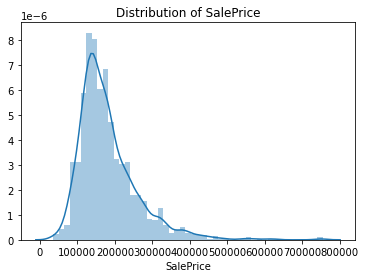

In [135]:
sns.distplot(train_df_no_outliers['SalePrice']).set_title("Distribution of SalePrice")

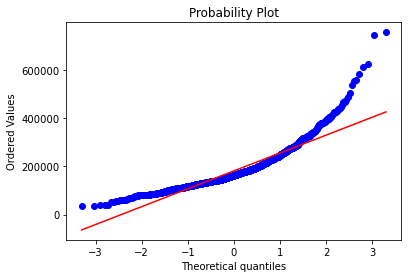

In [136]:
fig = plt.figure()
res = stats.probplot(train_df_no_outliers['SalePrice'], plot=plt)

In [137]:
#Using the log1p function applies log(1+x) to all elements of the column
train_df_no_outliers["SalePrice"] = np.log1p(train_df_no_outliers["SalePrice"])

c:\python3.7.8\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Distribution of SalePrice')

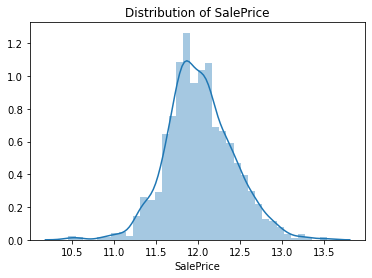

In [138]:
sns.distplot(train_df_no_outliers['SalePrice']).set_title("Distribution of SalePrice")

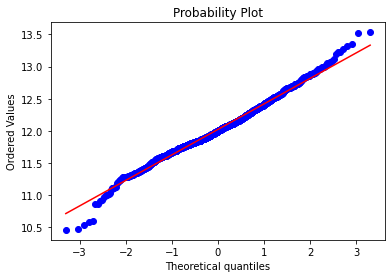

In [139]:
fig = plt.figure()
res = stats.probplot(train_df_no_outliers['SalePrice'], plot=plt)

## After transforming the salePrice to have normal distribution, we have reduced the Right skewness in the data and this should generally improve the performance of the models. Let's see which of our models gives the better performance now

In [140]:
# We have transformed the 'salePrice' on whole of our data, so let's split that to get the train and test data separately
train_data, test_data = shuffle_split_data(train_df_no_outliers)

## Now let's fit the tuned Models Random Forest and Gradient Boost regression models and check the performance

### 1) Random Forest Regression

In [141]:
Tuned_RFRM = RandomForestRegressor(max_features = 'auto', 
                                   min_samples_split = 2,
                                   max_depth = None,
                                   n_estimators = 3000,
                                   random_state = 195877,
                                   warm_start = True)

In [142]:
Tuned_RFRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

RandomForestRegressor(n_estimators=3000, random_state=195877, warm_start=True)

In [143]:
Tuned_RFRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9827660864120087

In [144]:
Tuned_RFRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.8820529573279148

### 2) Gradient Boost Regression

In [145]:
Tuned_GBRM = GradientBoostingRegressor(learning_rate = 0.02,
 max_depth = 4,
 n_estimators = 3000,
 random_state = 195877,
 subsample = 0.5)

In [146]:
Tuned_GBRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=3000,
                          random_state=195877, subsample=0.5)

In [147]:
Tuned_GBRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9990132167351831

In [148]:
Tuned_GBRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9040576437398787

### 3) Bayesian Ridge Regression

In [150]:
BestBRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

BayesianRidge()

In [151]:
BestBRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9206741073817067

In [152]:
BestBRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9111918087287757

### 4) Simple Linear Regression

In [153]:
BestLRM.fit(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

LinearRegression(n_jobs=-1)

In [154]:
BestLRM.score(train_data[tot_features_to_use].drop('SalePrice', axis = 1), train_data[tot_features_to_use]['SalePrice'])

0.9225614144665581

In [155]:
BestLRM.score(test_data[tot_features_to_use].drop('SalePrice', axis = 1), test_data[tot_features_to_use]['SalePrice'])

0.9094267203555231

## We were not able to use simple linear regression model on the transformed data, it errored out, so not including that in here

# ****************************END OF PART 2 ************************************

# PART 3) RESEARCH

### Let's Consider Feature selection for the research part as we have seen improvement after selecting the features manually by checking the correlation values

### Below are very frequently used techniques of feature selection for regression problems
### 1) StepWise Regression
### 2) Forward Selection
### 3) Backward Elemination
### 4) Forward Selection + Backward Elemination

### As the feature selection method that we used in Part 2 of this assignment, we have seen that it has least effect on RandomForest and Gradient boost regressor models, so for this case we will consider a simple linear regression model and build out our research part

## We will be making use of Backward Elimination process to select the features

In [156]:
# First let's read the data once again, apply all the preprocessing that we applied for all the features, except for 'SalePrice'
train_df = read_data("./house-prices-advanced-regression-techniques/train.csv")
test_df = read_data("./house-prices-advanced-regression-techniques/test.csv")
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop('Id', axis = 1, inplace = True)
train_df, test_df = preprocess_categorical_features(train_df, test_df)
train_df, test_df = handle_missing_values(train_df,test_df)

In [157]:
# Let's remove outliers using the same method (isolation forest and using minmax scaler to scale the values)
train_df_no_outliers, test_df = outlier_detection_and_removal(train_df, test_df, "isoforest","minmax")

# Let's split our training data to test the model performance at later stage
train_data, test_data = shuffle_split_data(train_df_no_outliers)

In [158]:
# Let's once have a look at the shape of train and test dataset:
print("train data shape: ", train_data.shape)
print("test data shape: ", test_data.shape)

train data shape:  (1156, 199)
test data shape:  (289, 199)


In [159]:
# Let's use our best performing Linear regression model to fit on this data and check how it is performing with all the features
BestLRM.fit(train_data.drop('SalePrice', axis = 1), train_data['SalePrice'])
print("R2 Score on Train data: ", BestLRM.score(train_data.drop('SalePrice', axis = 1), train_data['SalePrice']))
print("R2 Score on Test data: ", BestLRM.score(test_data.drop('SalePrice', axis = 1), test_data['SalePrice']))

R2 Score on Train data:  0.930168073268189
R2 Score on Test data:  0.899511265062054


#### We can see the difference between train and test score is 0.03 using all the features. Now we will do backward elimination process to select the features

In [160]:
import statsmodels.api as smf

In [161]:
X_train = train_data.drop('SalePrice', axis = 1)
y_train = train_data['SalePrice']

In [162]:
X_test = test_data.drop('SalePrice', axis = 1)
y_test = test_data['SalePrice']

Multivariate Linear regression equation is: x0 + x1theta1 + x2theta2 +... + xnthetan
where x1 to xn are features, theta1 to thetan are parameters (learnable) x0 is a bias (value is always 1) so to our dataset, we will add another column where each row will have a value of 1

In [163]:
X_train = np.append(arr = np.ones((1156,1)).astype(int), values=X_train, axis=1)

In [164]:
X_test = np.append(arr = np.ones((289,1)).astype(int), values=X_test, axis=1)

In [165]:
X_train.shape

(1156, 199)

In [166]:
X_test.shape

(289, 199)

In [167]:
regressor_OLS=smf.OLS(endog = y_train, exog=X_train).fit()  
regressor_OLS.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     70.29
Date:                Sun, 13 Dec 2020   Prob (F-statistic):               0.00
Time:                        22:21:59   Log-Likelihood:                -13147.
No. Observations:                1156   AIC:                         2.666e+04
Df Residuals:                     971   BIC:                         2.760e+04
Df Model:                         184                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.801e+05   4.91e+05     -0.977      0.329   -1.44e+06    4.84e+05
x1         -1.648e+04   1.61e+04     -1.023      0.306   -4.81e+04    1.51e+04
x2          4.074e+04   1.45e+04      2.809      0.005    1.23e+04    6.92e+04
x3           1.09e+05   2.12e+04      5.147      0.000    6.74e+04    1.51e+05
x4          9329.7944   1.34e+04      0.695      0.487    -1.7e+04    3.57e+04
x5         -1228.1490   3957.239     -0.310      0.756   -8993.875    6537.577
x6          2730.9895   1797.953      1.519      0.129    -797.331    6259.310
x7         -1928.9958   3093.309     -0.624      0.533   -7999.337    4141.345
x8          4.738e+04   2.71e+04      1.749      0.081   -5781.893    1.01e+05
x9          4848.4977   3637.144      1.333      0.183   -2289.071     1.2e+04
x10         8751.9080   1138.472      7.687      0.000    6517.760     1.1e+04
x11         5438.2136    972.234      5.594      0.000    3530.291    7346.136
x12          312.7536     86.149      3.630      0.000     143.694     481.813
x13           -7.7814     62.578     -0.124      0.901    -130.585     115.022
x14         5.382e+04   1.07e+04      5.024      0.000    3.28e+04    7.48e+04
x15         6550.4401   2339.424      2.800      0.005    1959.530    1.11e+04
x16        -1890.2116   2383.827     -0.793      0.428   -6568.257    2787.834
x17         3186.9634   1881.471      1.694      0.091    -505.254    6879.181
x18        -4781.2704   2406.947     -1.986      0.047   -9504.688     -57.853
x19         4939.0572    946.997      5.215      0.000    3080.662    6797.453
x20         -294.8331    565.791     -0.521      0.602   -1405.147     815.481
x21         1.051e+05   1.61e+04      6.536      0.000    7.35e+04    1.37e+05
x22          527.7643   1398.395      0.377      0.706   -2216.460    3271.989
x23         6413.5017   1.11e+04      0.577      0.564   -1.54e+04    2.82e+04
x24        -1.395e+04   7015.536     -1.988      0.047   -2.77e+04    -180.228
x25         9.327e+04   1.65e+04      5.666      0.000     6.1e+04    1.26e+05
x26         1425.5454   1080.373      1.319      0.187    -694.590    3545.681
x27          -43.1318   4273.484     -0.010      0.992   -8429.460    8343.196
x28         1.487e+05   1.68e+04      8.858      0.000    1.16e+05    1.82e+05
x29          8.69e+04   1.15e+04      7.556      0.000    6.43e+04    1.09e+05
x30        -1.208e+04   1.45e+04     -0.832      0.406   -4.06e+04    1.64e+04
x31         1.546e+05   1.32e+04     11.681      0.000    1.29e+05    1.81e+05
x32          839.4755   2224.244      0.377      0.706   -3525.403    5204.354
x33         2640.5796   3325.182      0.794      0.427   -3884.792    9165.951
x34          943.0864   2511.664      0.375      0.707   -3985.829    5872.001
x35         1746.2672   2363.746      0.739      0.460   -2892.372    6384.907
x3

In [168]:
# https://www.kaggle.com/ashishsaxena2209/step-by-step-regression-backward-elimination

def DoBackwardElimination(the_regressor, X, y, minP2eliminate):
    
    assert np.shape(X)[0] == np.shape(y)[0], 'Length of X and y do not match'
    assert minP2eliminate > 0, 'Minimum P value to eliminate cannot be zero or negative'
    
    original_list = list(range(0, np.shape(the_regressor.pvalues)[0]))
    
    max_p = 10        # Initializing with random value of maximum P value
    i = 0
    r2adjusted = []   # Will store R Square adjusted value for each loop
    r2 = []           # Will store R Square value  for each loop
    list_of_originallist = [] # Will store modified index of X at each loop
    classifiers_list = [] # fitted classifiers at each loop
    
    while max_p >= minP2eliminate:
        
        p_values = list(the_regressor.pvalues)
        r2adjusted.append(the_regressor.rsquared_adj)
        r2.append(the_regressor.rsquared)
        list_of_originallist.append(original_list)
        
        max_p = max(p_values)
        max_p_idx = p_values.index(max_p)
        
        if max_p_idx == 0:
            
            temp_p = set(p_values)
            
            # removing the largest element from temp list
            temp_p.remove(max(temp_p))
            
            max_p = max(temp_p)
            max_p_idx = p_values.index(max_p)
            
            print('Index value 0 found!! Next index value is {}'.format(max_p_idx))
            
            if max_p < minP2eliminate:
                
                print('Max P value found less than 0.1 with 0 index ...Loop Ends!!')
                
                break
                
        if max_p < minP2eliminate:
            
            print('Max P value found less than 0.1 without 0 index...Loop Ends!!')
            
            break
        
        val_at_idx = original_list[max_p_idx]
        
        idx_in_org_lst = original_list.index(val_at_idx)
        
        original_list.remove(val_at_idx)
        
        print('Popped column index out of original array is {} with P-Value {}'.format(val_at_idx, np.round(np.array(p_values)[max_p_idx], decimals= 4)))
        
        X_new = X[:, original_list]
        
        the_regressor = smf.OLS(endog = y, exog = X_new).fit()
        classifiers_list.append(the_regressor)
        
        print('==================================================================================================')
        
    return classifiers_list, r2, r2adjusted, list_of_originallist

In [169]:
regressor_list, r2, r2adjusted, list_of_changes = DoBackwardElimination(the_regressor=regressor_OLS, 
                                                                        X= X_train, y= y_train, minP2eliminate = 0.05)

Popped column index out of original array is 78 with P-Value 0.9977
Popped column index out of original array is 66 with P-Value 0.9994
Popped column index out of original array is 27 with P-Value 0.992
Popped column index out of original array is 122 with P-Value 0.9868
Popped column index out of original array is 170 with P-Value 0.9767
Popped column index out of original array is 43 with P-Value 0.9762
Popped column index out of original array is 134 with P-Value 0.9593
Popped column index out of original array is 102 with P-Value 0.9934
Popped column index out of original array is 155 with P-Value 0.9398
Popped column index out of original array is 99 with P-Value 0.9193
Popped column index out of original array is 57 with P-Value 0.9149
Popped column index out of original array is 13 with P-Value 0.9002
Popped column index out of original array is 47 with P-Value 0.8137
Popped column index out of original array is 178 with P-Value 0.8208
Popped column index out of original array i

Popped column index out of original array is 100 with P-Value 0.3567
Popped column index out of original array is 9 with P-Value 0.3024
Popped column index out of original array is 136 with P-Value 0.3067
Popped column index out of original array is 42 with P-Value 0.2902
Popped column index out of original array is 41 with P-Value 0.3987
Popped column index out of original array is 141 with P-Value 0.2791
Popped column index out of original array is 146 with P-Value 0.9916
Popped column index out of original array is 150 with P-Value 0.6883
Popped column index out of original array is 144 with P-Value 0.8192
Popped column index out of original array is 130 with P-Value 0.5483
Popped column index out of original array is 143 with P-Value 0.5483
Popped column index out of original array is 140 with P-Value 0.4602
Popped column index out of original array is 151 with P-Value 0.4634
Popped column index out of original array is 139 with P-Value 0.3615
Popped column index out of original ar

Popped column index out of original array is 18 with P-Value 0.2375
Popped column index out of original array is 128 with P-Value 0.092
Popped column index out of original array is 133 with P-Value 0.0887
Popped column index out of original array is 30 with P-Value 0.1062
Popped column index out of original array is 31 with P-Value 0.9166
Popped column index out of original array is 138 with P-Value 0.07
Popped column index out of original array is 103 with P-Value 0.0629
Popped column index out of original array is 153 with P-Value 0.051
Max P value found less than 0.1 without 0 index...Loop Ends!!


In [170]:
new_list = list_of_changes[1]

In [171]:
len(new_list)

92

so we now have 92 features selected using backward elimination out of 198 features (we have eliminated 106 features). Lets make use of those 92 features to get our new train and test data set and check how the Linear regression model performs

In [172]:
new_X_train = X_train[:,new_list]

In [173]:
new_X_train.shape

(1156, 92)

In [174]:
new_X_test = X_test[:, new_list]

In [175]:
new_X_test.shape

(289, 92)

In [176]:
BestLRM.fit(new_X_train, y_train)

LinearRegression(n_jobs=-1)

In [177]:
BestLRM.score(new_X_train, y_train)

0.9236011642819651

In [178]:
BestLRM.score(new_X_test, y_test)

0.9005244776400707

In [179]:
0.9236 - 0.9005

0.02310000000000001

## Let's check if we get any difference in performance of Random Forest, Gradient boost and Bayesian Ridge regression models

In [180]:
Tuned_RFRM = RandomForestRegressor(max_features = 'auto', 
                                   min_samples_split = 2,
                                   max_depth = None,
                                   n_estimators = 3000,
                                   random_state = 195877,
                                   warm_start = True)

In [181]:
Tuned_RFRM.fit(new_X_train, y_train)

RandomForestRegressor(n_estimators=3000, random_state=195877, warm_start=True)

In [182]:
Tuned_RFRM.score(new_X_train, y_train)

0.981686786181487

In [183]:
Tuned_RFRM.score(new_X_test, y_test)

0.88013226919887

In [184]:
Tuned_GBRM = GradientBoostingRegressor(learning_rate = 0.02,
 max_depth = 4,
 n_estimators = 3000,
 random_state = 195877,
 subsample = 0.5)

In [185]:
Tuned_GBRM.fit(new_X_train, y_train)

GradientBoostingRegressor(learning_rate=0.02, max_depth=4, n_estimators=3000,
                          random_state=195877, subsample=0.5)

In [186]:
Tuned_GBRM.score(new_X_train, y_train)

0.9991754110027975

In [187]:
Tuned_GBRM.score(new_X_test, y_test)

0.9177264285241813

In [188]:
BestBRM.fit(new_X_train, y_train)

BayesianRidge()

In [189]:
BestBRM.score(new_X_train, y_train)

0.9230882947917883

In [190]:
BestBRM.score(new_X_test, y_test)

0.9014601266619305

In [191]:
0.9230 - 0.9014

0.021600000000000064

## so, we can see that after backward elimination the difference between train and test R2 score has reduced to 0.023. Not a significant improvement, but we are successfull in reducing the overfitting by a bit

# **************END OF PART3**********************